In [ ]:
####################
##### Final HW #####
####################

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from google.colab import drive
drive.mount('/content/drive')

## Load data
mushrooms = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BigData_Basic/Mushroom/Mushroom/agaricus-lepiota.data')

## Replace columns
mushrooms.columns = ["class",
                     "cap-shape",
                     "cap-surface",
                     "cap-color",
                     "bruises",
                     "odor",
                     "gill-attachment",
                     "gill-spacing",
                     "gill-size",
                     "gill-color",
                     "stalk-shape",
                     "stalk-root",
                     "stalk-surface-above-ring",
                     "stalk-surface-below-ring",
                     "stalk-color-above-ring",
                     "stalk-color-below-ring",
                     "veil-type",
                     "veil-color",
                     "ring-number",
                     "ring-type",
                     "spore-print-color",
                     "population",
                     "habitat"]

## Add deleted data
deleted_data = {'class':'p',
								'cap-shape':'x',
								'cap-surface':'s',
								'cap-color':'n',
								'bruises':'t',
								'odor':'p',
								'gill-attachment':'f',
								'gill-spacing':'c',
								'gill-size':'n',
								'gill-color':'k',
								'stalk-shape':'e',
								'stalk-root':'e',
								'stalk-surface-above-ring':'s',
								'stalk-surface-below-ring':'s',
								'stalk-color-above-ring':'w',
								'stalk-color-below-ring':'w',
								'veil-type':'p',
								'veil-color':'w',
								'ring-number':'o',
								'ring-type':'p',
								'spore-print-color':'k',
								'population':'s',
								'habitat':'u',}

mushrooms = mushrooms.append(deleted_data, ignore_index = True) 

Mounted at /content/drive


In [ ]:
## Information Gain method to select the two attributes that have the most influence
def entropy(labels):
    entropy=0
    label_counts = Counter(labels)
    for label in label_counts:
        prob_of_label = label_counts[label] / len(labels)
        entropy -= prob_of_label * math.log2(prob_of_label)
    return entropy

def get_IG(starting_labels, split_labels):
    info_gain = entropy(starting_labels)
    for branched_subset in split_labels:
        info_gain -= entropy(branched_subset)*( len(branched_subset) / len(starting_labels) )
    return info_gain
  
def split(dataset, column):
    split_data = []
    col_vals = mushrooms[column].unique()
    for col_val in col_vals:
        split_data.append(dataset[dataset[column] == col_val])
    return(split_data)

def find_two_attributes(dataset):
    best_gain = 0
    best_feature = 0
    second_gain = 0
    second_feature = 0

    features = list(dataset.columns)
    features.remove('class')

    for feature in features:
        split_data = split(dataset, feature)
        split_labels = [dataframe['class'] for dataframe in split_data]
        gain = get_IG(dataset['class'], split_labels)

        if gain > best_gain:
            best_gain, best_feature = gain, feature

        elif second_gain < gain < best_gain:
            second_gain, second_feature = gain, feature

    Best = [best_feature,best_gain]
    Second = [second_feature, second_gain]
    return Best, Second

print(find_two_attributes(mushrooms))

(['odor', 0.9060749773839998], ['spore-print-color', 0.4807049176849153])


Accuracy: 0.9846153846153847
AUC of ROC curve: 0.9989280806229959
AUC of precision recall curve: 0.9990942731432783


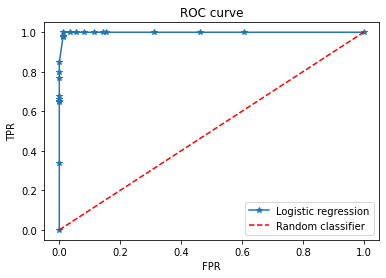

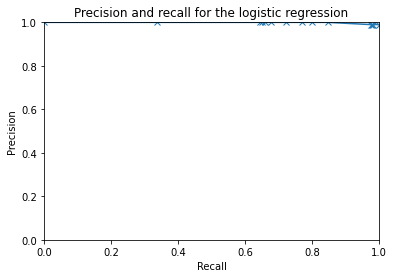

In [ ]:
## Data preprocessing
X_1 = find_two_attributes(mushrooms)[0][0]
X_2 = find_two_attributes(mushrooms)[1][0]
X1 = mushrooms.loc[:,X_1] # 'odor'
X2 = mushrooms.loc[:,X_2] # 'spore-print-color'
X = pd.concat([X1,X2], axis=1)

X = pd.get_dummies(X) # one-hot endcoding
Y = mushrooms.loc[:,'class'].map(lambda x : 0 if x =='p' else 1 ) # label encoding -> e:1, p:0

## Training
X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values, test_size=0.2, random_state=24) 
mushroom_lr = LogisticRegression(C=0.1, 
                                 class_weight=None, 
                                 dual=False, 
                                 fit_intercept=True, 
                                 intercept_scaling=1, 
                                 max_iter=100, 
                                 multi_class='auto', 
                                 n_jobs=None, 
                                 penalty='l2', 
                                 random_state=None, 
                                 solver='liblinear',
                                 tol=0.0001, 
                                 verbose=0, 
                                 warm_start=False)

mushroom_lr.fit(X_train, y_train) # fitting
y_pred = mushroom_lr.predict(X_test)
is_correct = y_pred == y_test
print("Accuracy:",np.mean(is_correct))

## Obtaining Predicted Probabilities
y_pred_proba = mushroom_lr.predict_proba(X_test) 
pos_proba = y_pred_proba[:,1] # positive probability

## Plot ROC curve & Calculate AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_proba)
print("AUC of ROC curve:",metrics.roc_auc_score(y_test, pos_proba))
fig1 = plt.figure()
plt.plot(fpr, tpr, '*-')
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(['Logistic regression', 'Random classifier'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

## Plot precision recall curve & Calculate AUC
precision, recall, thresh_3 = metrics.precision_recall_curve(y_test, pos_proba)
print("AUC of precision recall curve:",metrics.auc(recall, precision))
fig2 = plt.figure()
plt.plot(recall, precision, '-x')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision and recall for the logistic regression')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()